# Coding 1 Home Assignment 1
### Authors: Mátyás Kovács & Márton Nagy

Let's import the necessary packages for the analysis.

In [1]:
import pandas as pd
import math
import numpy as np
from plotnine import *
import patchworklib as pw
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import display
from mizani.formatters import percent_format
import copy
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

First, we read the source datafile that was uploaded to Moodle.

In [151]:
raw = pd.read_csv('used-cars.csv')
raw.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


In [153]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pricestr      549 non-null    object 
 1   area          549 non-null    object 
 2   subarea       540 non-null    object 
 3   name          549 non-null    object 
 4   condition     327 non-null    object 
 5   cylinders     360 non-null    object 
 6   drive         294 non-null    object 
 7   fuel          548 non-null    object 
 8   odometer      549 non-null    float64
 9   paintcolor    316 non-null    object 
 10  size          193 non-null    object 
 11  transmission  549 non-null    object 
 12  type          301 non-null    object 
 13  dealer        549 non-null    int64  
 14  price         549 non-null    int64  
 15  lnprice       549 non-null    float64
 16  year          549 non-null    int64  
 17  age           549 non-null    int64  
 18  lnodometer    549 non-null    

In [155]:
raw.drop_duplicates(inplace=True)

In [157]:
raw.area.unique()

array(['chicago', 'los angeles'], dtype=object)

In [159]:
raw = raw.filter(['name', 'area', 'price', 'age'])
raw.describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,549.00,5866.15,5657.67,1.00,950.00,2400.00,4300.00,8299.00,14990.60,90002.00
age,549.00,12.18,5.89,1.00,3.00,8.00,12.00,16.00,21.00,27.00


In [161]:
raw['price'] = raw['price'] / 1000

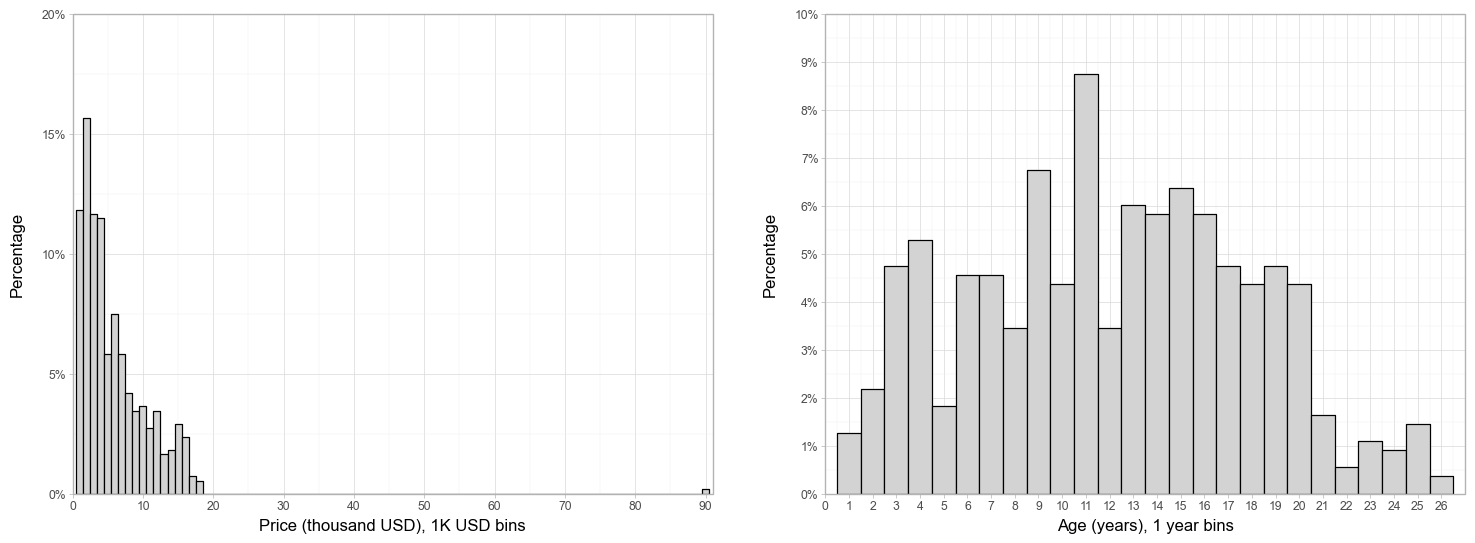

In [163]:
pw.basefigure.clear()
p1 = (
    ggplot(raw)
    + aes(x = 'price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 91),
        breaks=range(0, 91,10)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.2),
        breaks=np.arange(0,0.21,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'Price (thousand USD), 1K USD bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(raw)
    + aes(x = 'age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 27),
        breaks=range(0, 27, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Age (years), 1 year bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

In [165]:
raw['ln_price'] = np.log(raw['price'])
raw['ln_age'] = np.log(raw['age'])

In [167]:
raw[['ln_price','ln_age']].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
ln_price,549.00,1.39,1.02,-6.91,-0.05,0.88,1.46,2.12,2.71,4.50
ln_age,549.00,2.34,0.65,0.00,1.10,2.08,2.48,2.77,3.04,3.30


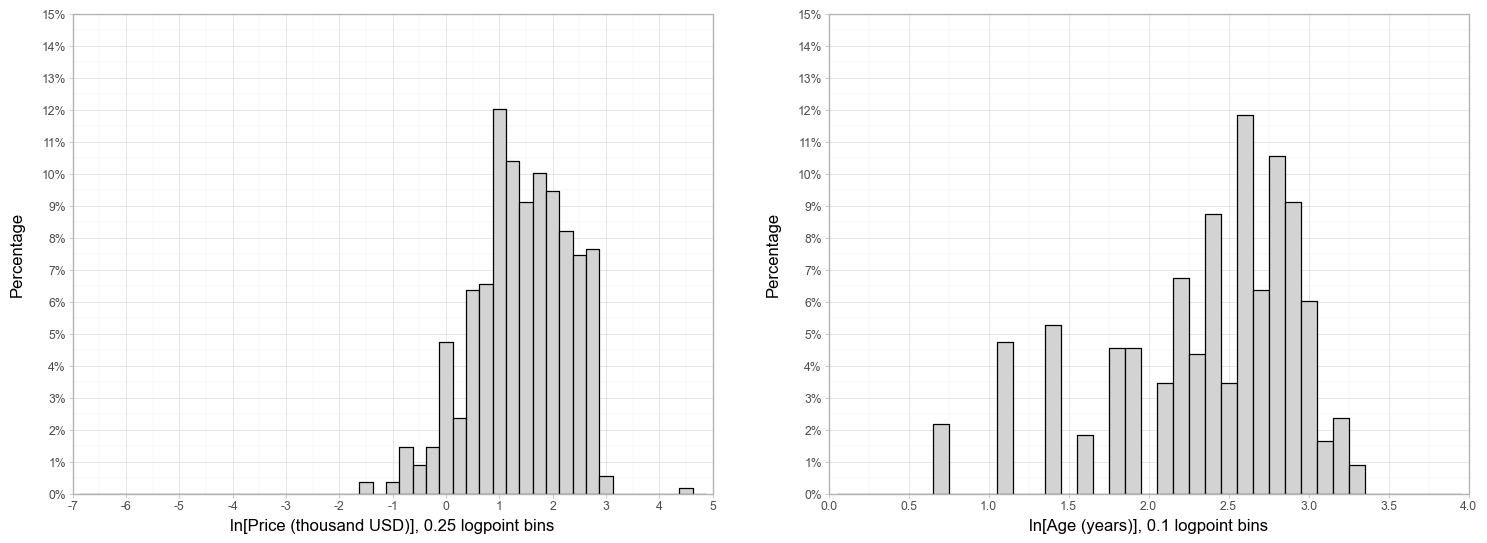

In [169]:
pw.basefigure.clear()
p1 = (
    ggplot(raw)
    + aes(x = 'ln_price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.25
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-7, 5),
        breaks=np.arange(-7, 5.1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Price (thousand USD)], 0.25 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(raw)
    + aes(x = 'ln_age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 4),
        breaks=np.arange(0, 4.1, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Age (years)], 0.1 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

In [171]:
chicago = raw[raw['area'] == 'chicago']
la = raw[raw['area'] == 'los angeles']

In [173]:
chicago.describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,327.00,5.96,4.52,0.21,0.88,2.30,4.40,8.97,14.99,18.50
age,327.00,12.19,5.98,1.00,3.00,7.00,12.00,17.00,21.00,27.00
ln_price,327.00,1.45,0.88,-1.58,-0.13,0.83,1.48,2.19,2.71,2.92
ln_age,327.00,2.33,0.65,0.00,1.10,1.95,2.48,2.83,3.04,3.30


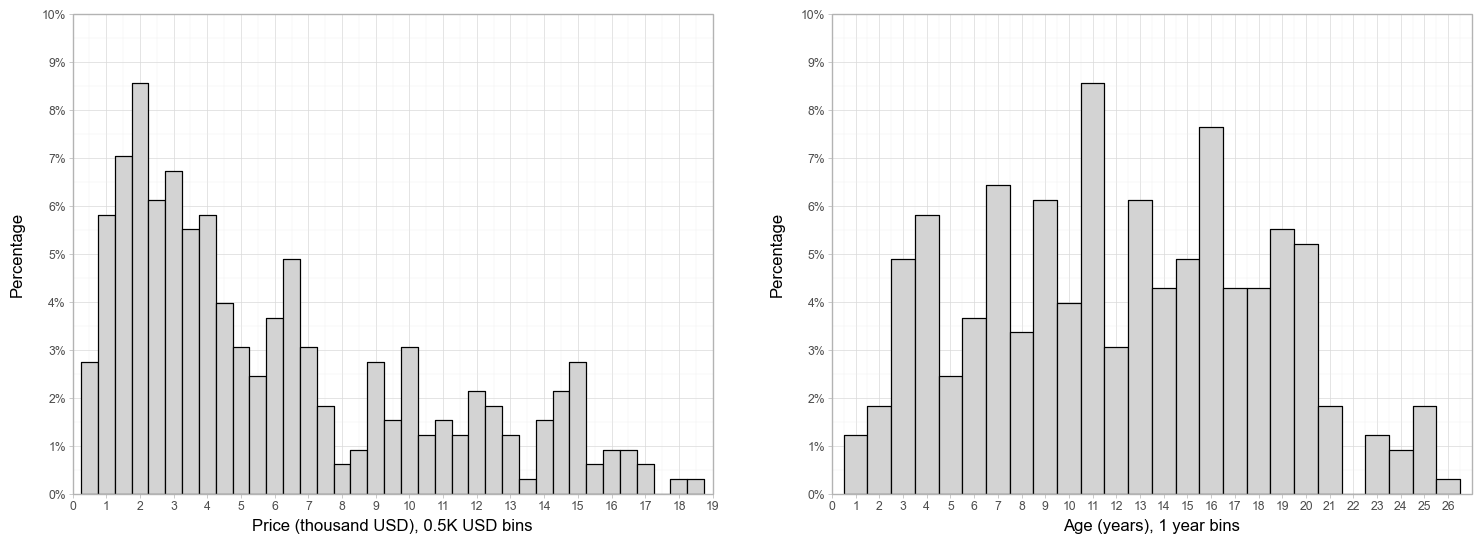

In [181]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 19),
        breaks=range(0, 20,1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Price (thousand USD), 0.5K USD bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(chicago)
    + aes(x = 'age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 27),
        breaks=range(0, 27, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Age (years), 1 year bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

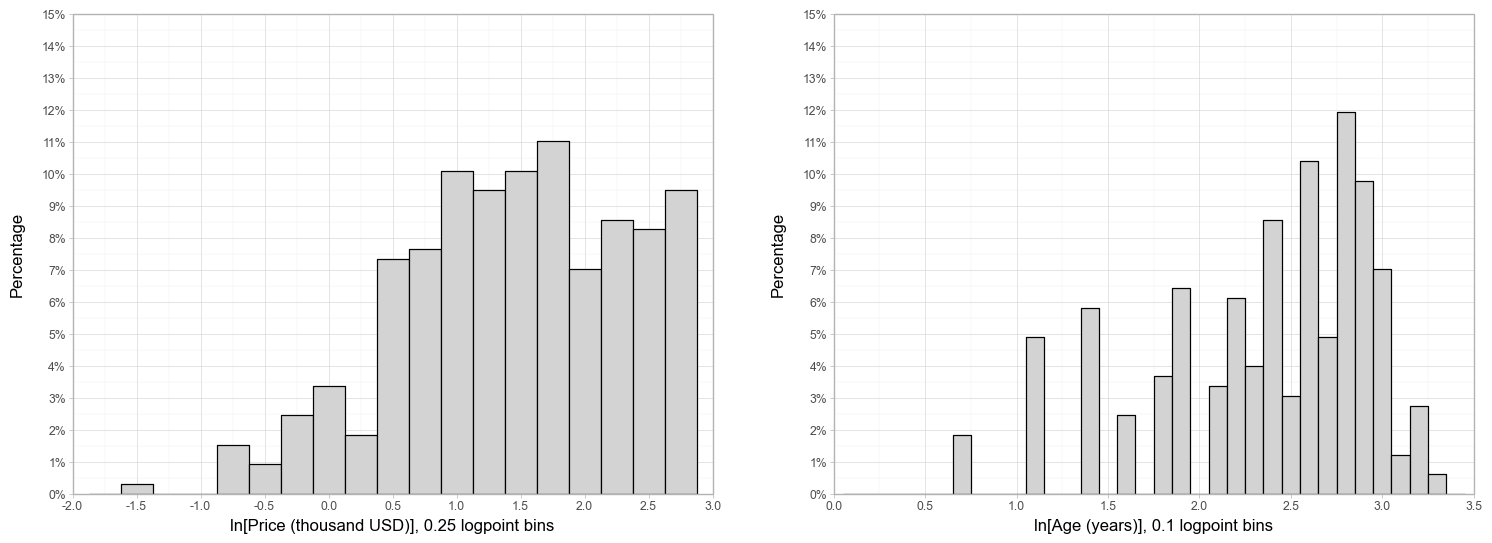

In [187]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'ln_price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.25
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-2, 3),
        breaks=np.arange(-2, 3.1, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Price (thousand USD)], 0.25 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(chicago)
    + aes(x = 'ln_age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 3.5),
        breaks=np.arange(0, 3.51, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Age (years)], 0.1 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()